In [1]:
%pylab inline
import glob
import homer
import dask.dataframe as dd
import pandas as pd
import numpy as np
import pickle
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
collection = homer.Homer(weighted_edge_list_globstring='tests/resources/Making_Connections_Generated_Data.hdf')

In [3]:
collection.compute_clusters('working/MC_gen_clusters_*.hdf', min_threshold=1)

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/core.py:2738: UserWarning: `columns` is deprecated, please use `meta` instead
  warnings.warn("`columns` is deprecated, please use `meta` instead")
/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/dataframe/core.py:2748: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [4]:
collection.compute_relations('working/MC_gen_relations_*.hdf')

In [5]:
collection.compute_tree()

In [6]:
root = collection.tree

KeyboardInterrupt: 

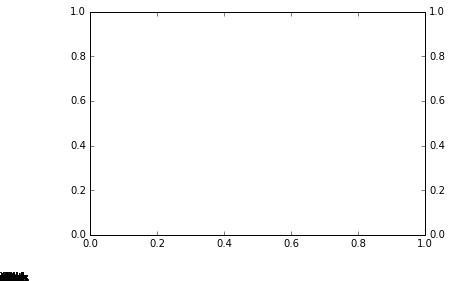

In [12]:
ax = plt.gca()
ax_test = ax.twinx()
root.layout(ax_test)

In [33]:
a = root.find('-2943944007688239924')

In [34]:
a

-2943944007688239924

In [35]:
a.k_children

[honour, peace, upon, share, wear, live, fewer]

In [38]:
b = root.find('-4702866424366699832')
b.k_children

[-2943944007688239924,
 outward,
 pray,
 markd,
 wish,
 dwell,
 one,
 things,
 cost,
 covet]

In [ ]:
a.k_children[2]

In [ ]:
b.k_children[5]

In [ ]:
for n in homer.tree.walk_k_ancestry(root):
    print(n.k_children)

In [ ]:
a.k_children[2] is b.k_children[5]

In [31]:
collection.clusters[collection.clusters['k']==7].compute()

,Set,k,threshold,Date
ID,,,,
-2943944007688239924,peace share live upon honour wear fewer,7,1,1


In [37]:
collection.clusters[(collection.clusters['k']==6)].compute()

,Set,k,threshold,Date
ID,,,,
-8596872330028569940,peace share live wish fewer honour wear,6,2,3
-8596875237009315315,peace share live wish fewer honour wear,6,4,4
-8596870876536325890,peace share live wish fewer honour wear,6,3,4
-5853114226745766784,peace share live wish wear fewer honour upon,6,1,3
-4702866424366699832,outward peace share live pray markd wish dwell...,6,1,1
-2948239378724855240,care share markd wish dwell covet,6,1,1
-3346707278463544760,live one fewer honour things wear cost,6,1,3
-3172245855120495490,live one fewer honour things wear,6,2,4
-2861959016774172950,peace share live wish wear fewer honour,6,2,4
